In [1]:
import matplotlib.pyplot as plt
from itertools import product

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

In [2]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

In [3]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        '''
        This should fit the tree classifier. 
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''

        self.split_id = -1
        if len(X) > self.min_sample and self.depth < self.max_depth:
            # Attempt to split this node
            self.split_value = np.inf
            min_loss = self.split_loss_function(y)

            for attr_id in range(X.shape[1]):
                attr_value = sorted(list(set(X[:, attr_id])))
                for i in range(len(attr_value) - 1):
                    v = (attr_value[i] + attr_value[i + 1]) / 2. #compute midpoint

                    left_index_temp = np.where(X[:, attr_id] <= v)[0]
                    right_index_temp = np.where(X[:, attr_id] > v)[0]

                    left_loss = self.split_loss_function(y[left_index_temp])
                    right_loss = self.split_loss_function(y[right_index_temp])

                    split_loss = (len(left_index_temp) * left_loss + len(right_index_temp) * right_loss) / float(len(y))

                    if split_loss < min_loss: # if loss decreases, update split_id and split_value 
                        self.split_id = attr_id
                        self.split_value = v
                        min_loss = split_loss

        if self.split_id == -1:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self

        # Create subtree on left and right
        self.is_leaf = False

        self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                          depth=self.depth+1, min_sample=self.min_sample,  max_depth=self.max_depth)
        self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                          depth=self.depth+1, min_sample=self.min_sample,  max_depth=self.max_depth)
        left_index = np.where(X[:, self.split_id] <= self.split_value)
        right_index = np.where(X[:, self.split_id] > self.split_value)
        self.left.fit(X[left_index], y[left_index])
        self.right.fit(X[right_index], y[right_index])
        return self

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation of given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    median_value = np.median(y)
    mae = np.mean((abs(y - median_value)))
    return mae

class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Classification Tree specific code

def compute_entropy(y):
    '''
    Calulate the entropy of given label list
    
    :param y: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    label_cnt = Counter(y.reshape(len(y)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    entropy = 0.
    for prob in prob_list:
        if prob == 0.:
            pass
        else:
            entropy += -1. * prob * np.log(prob)
    return entropy

def compute_gini(y):
    '''
    Calulate the gini index of label list
    
    :param y: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    label_cnt = Counter(y.reshape(len(y)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    gini = 0.
    for prob in prob_list:
        gini += prob * (1 - prob)
    return gini

def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Loading Data

In [4]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [5]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Boundary

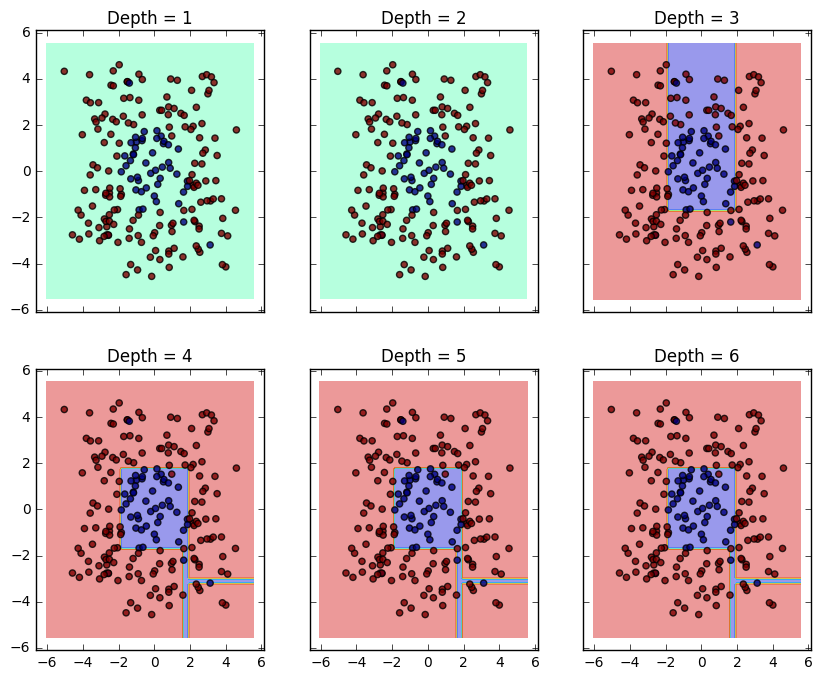

In [6]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [7]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [8]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

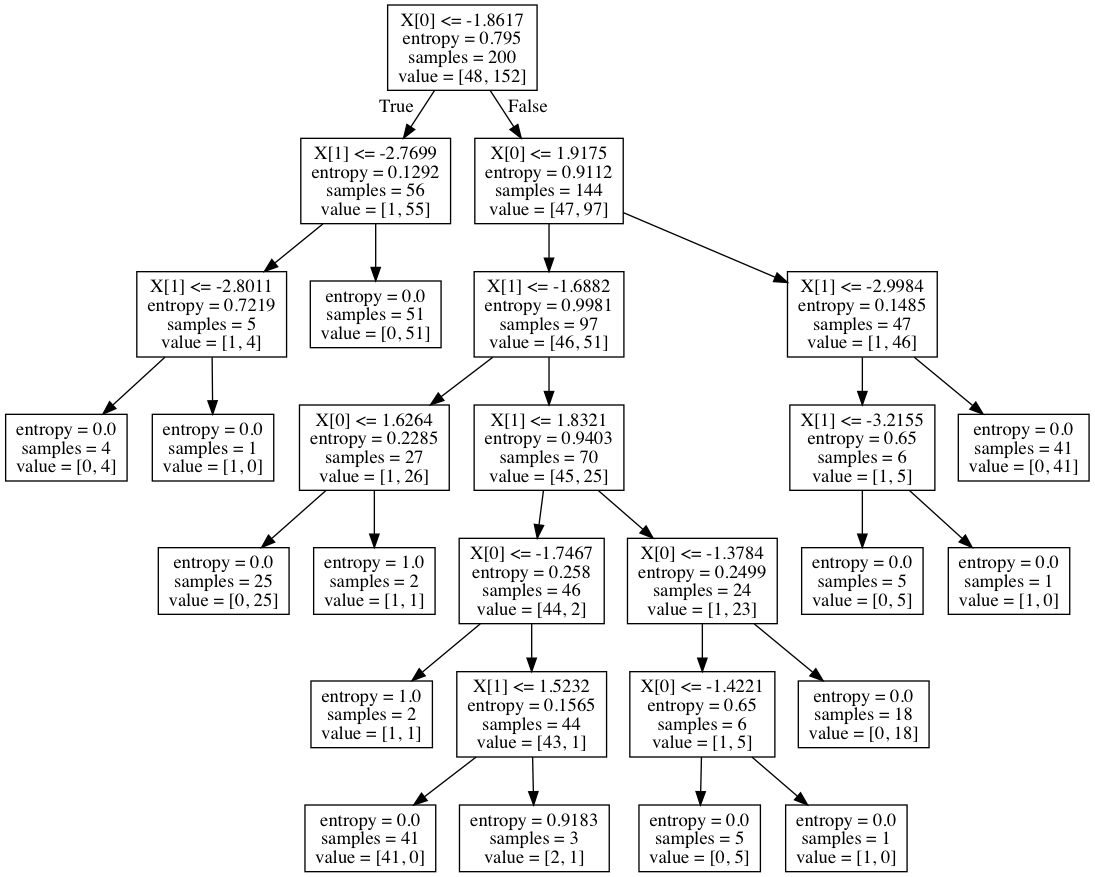

In [9]:
Image(filename='tree_classifier.png')

In [10]:
# compare first splitting point
print('Split_id of root node: {}'.format(clf2.tree.split_id))
print('Split_value of root node: {}'.format(clf2.tree.split_value))

Split_id of root node: 0
Split_value of root node: -1.8616606665


# Regression Tree

In [11]:
tree_reg = Regression_Tree(max_depth=5)
tree_reg.fit(x_train, y_train)

<__main__.Regression_Tree instance at 0x1102ecb48>

# Compare decision tree with tree model in sklearn

In [12]:
treg_sk = DecisionTreeRegressor(max_depth=3, min_samples_split=5, criterion='mse')
treg_sk.fit(x_train, y_train)
export_graphviz(treg_sk, out_file='tree_regressor.dot')

In [13]:
!dot -Tpng tree_regressor.dot -o tree_regressor.png

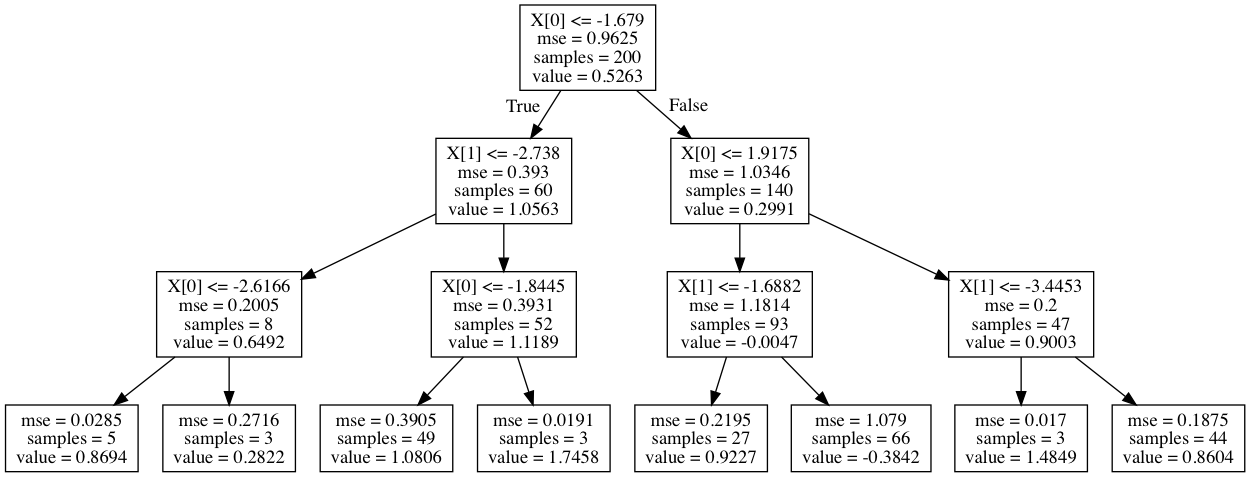

In [14]:
Image(filename='tree_regressor.png')

In [15]:
# compare first splitting point
print('Split_id of root node: {}'.format(tree_reg.tree.split_id))
print('Split_value of root node: {}'.format(tree_reg.tree.split_value))

Split_id of root node: 0
Split_value of root node: -1.67902733099


# Fit regression tree to 1-dim regression data

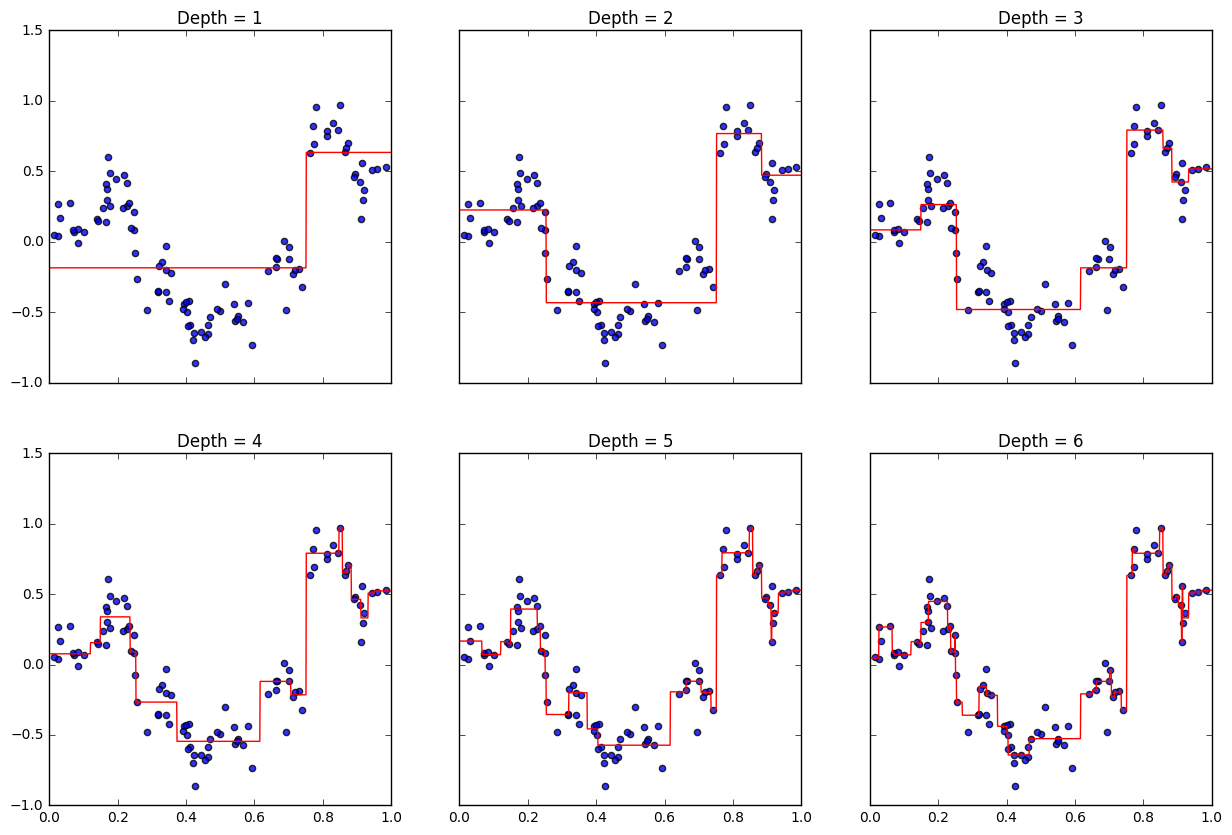

In [16]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()



# Gradient Boosting

In [17]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [18]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        predict_value = np.zeros((len(train_target), 1))
        pseodo_residual = self.pseudo_residual_func(train_target, predict_value)
        model_dict = {}
        for i in range(self.n_estimator):
            decision_stump = Regression_Tree(min_sample=self.min_sample, max_depth=self.max_depth)
            decision_stump.fit(train_data, pseodo_residual)
            model_dict[i] = decision_stump
            predict_value += self.learning_rate * np.array([decision_stump.predict_instance(x) for x in train_data]).reshape(-1, 1)
            pseodo_residual = self.pseudo_residual_func(train_target, predict_value)
        self.model_dict = model_dict
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        predict_vector = np.zeros((len(test_data), 1))
        for i in range(self.n_estimator):
            predict_temp = np.array([self.model_dict[i].predict_instance(x) for x in test_data]).reshape(-1, 1)
            predict_vector += self.learning_rate * predict_temp
        return predict_vector

# Gradient Boosting Visualization

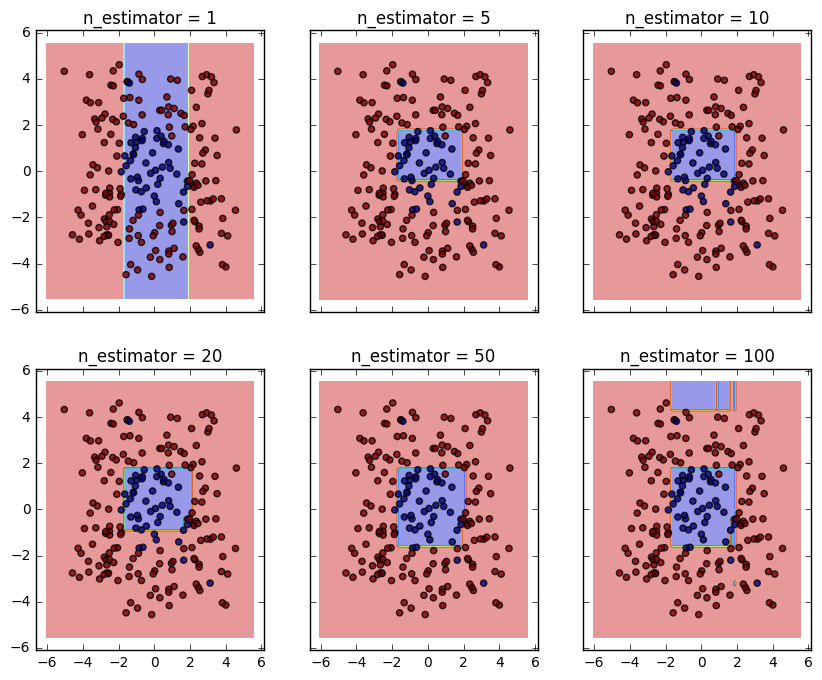

In [19]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

# 1-D GBM visualization

In [20]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')

In [21]:
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

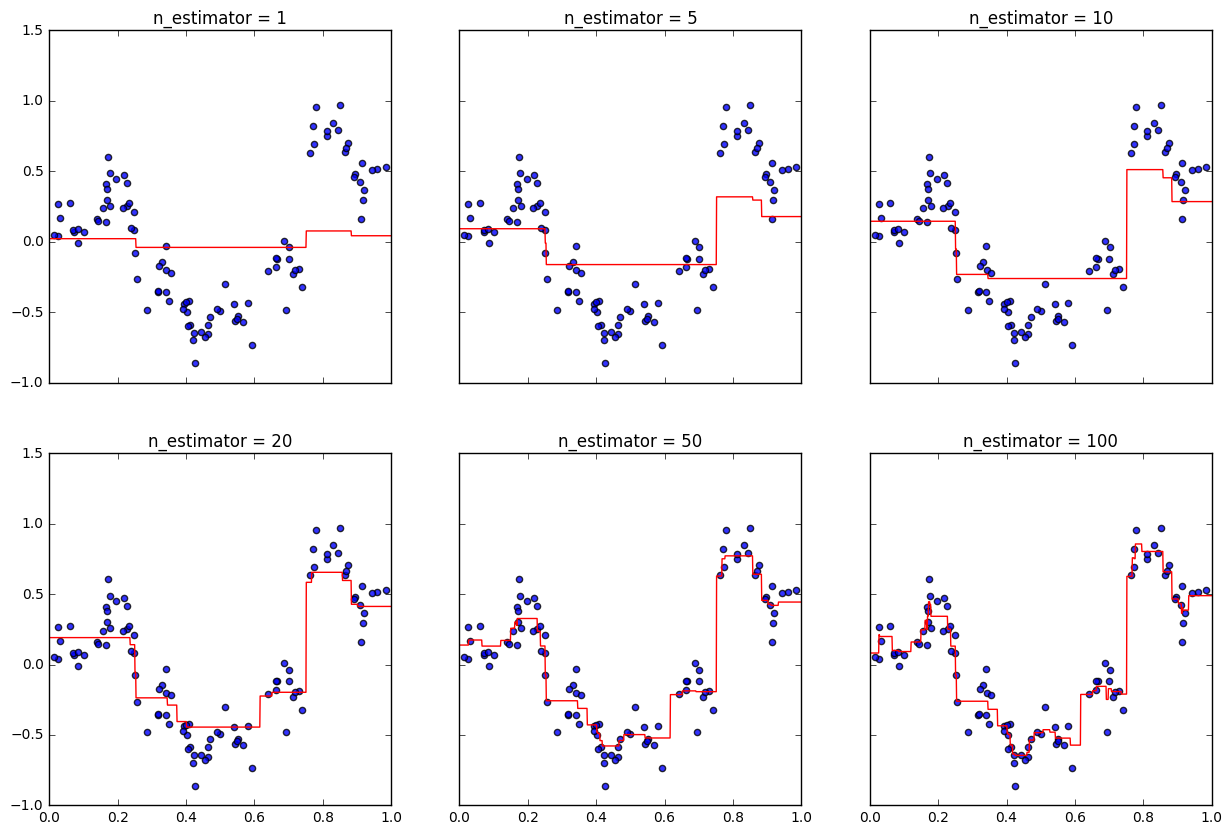

In [22]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)